## Access Satellite GHRSST L4 Ramssa 1Day Multi Sensor Australia data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l4_ramssa_1day_multi_sensor_australia dataset available as a [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a4170ca8-0942-4d13-bdb8-ad4718ce14bb).

In [1]:
dataset_name = "satellite_ghrsst_l4_ramssa_1day_multi_sensor_australia"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 34ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

In [4]:
# remote zarr dataset
aodn = GetAodn()
dname = f'{dataset_name}.zarr'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 488 ms, sys: 56.8 ms, total: 545 ms
Wall time: 1.21 s


In [5]:
ds = aodn_dataset.zarr_store
ds.info()

xarray.Dataset {
dimensions:
	time = 6923 ;
	lat = 1081 ;
	lon = 1561 ;

variables:
	float64 analysed_sst(time, lat, lon) ;
		analysed_sst:comment = Optimally interpolated analysis of SST observations. ;
		analysed_sst:coverage_content_type = physicalMeasurement ;
		analysed_sst:grid_mapping = crs ;
		analysed_sst:long_name = analysed sea surface temperature ;
		analysed_sst:source = NAR15_SST-ABOM,NAR17_SST-ABOM,NAR18_SST-ABOM,AVHRR15_G-OSDPD,AVHRR17_G-OSDPD,AVHRR18_G-OSDPD,ATS_MET_2P-ESA,AMSRE-REMSS,IN_SITU-GTS_BUOYS,IN_SITU-GTS_BATHY,IN_SITU-GTS_SHIP,IN_SITU-GTS_TESAC,LAPS-WSP,NCEP-ICE ;
		analysed_sst:standard_name = sea_surface_foundation_temperature ;
		analysed_sst:units = kelvin ;
		analysed_sst:valid_max = 4500 ;
		analysed_sst:valid_min = -300 ;
	float64 analysis_error(time, lat, lon) ;
		analysis_error:comment = Calculated as analysis field error in OI analysis system and a function of the age and estimated standard deviation of all observations used to form analysed_sst val

## Plot time coverage

In [6]:
aodn_dataset.get_temporal_extent()

(Timestamp('2006-06-12 12:00:00'), Timestamp('2025-06-09 12:00:00'))

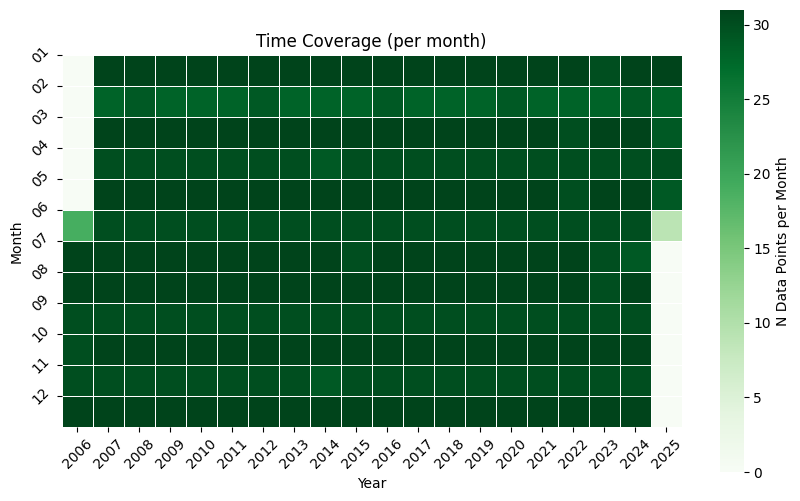

In [7]:
aodn_dataset.plot_time_coverage()

## Timeseries at a point

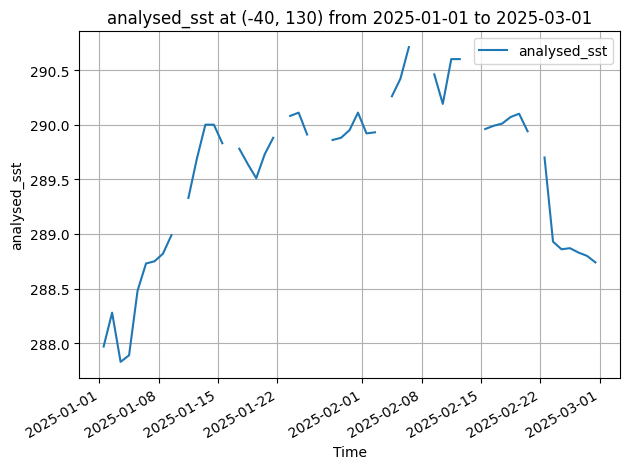

CPU times: user 1.05 s, sys: 248 ms, total: 1.29 s
Wall time: 3.49 s


In [8]:
%%time
time_series_df = aodn_dataset.get_timeseries_data(var_name='analysed_sst', 
                                                  lat=-40, 
                                                  lon=130, 
                                                  date_start='2025-01-01', 
                                                  date_end='2025-03-01', 
                                                  lon_name_override="lon", 
                                                  lat_name_override="lat").plot_timeseries()

## Plot a gridded variable

2025-06-11 12:27:38,937 - aodn.GetAodn - INFO - Plotting 'analysed sea surface temperature' for 6 time steps.
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2510: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(


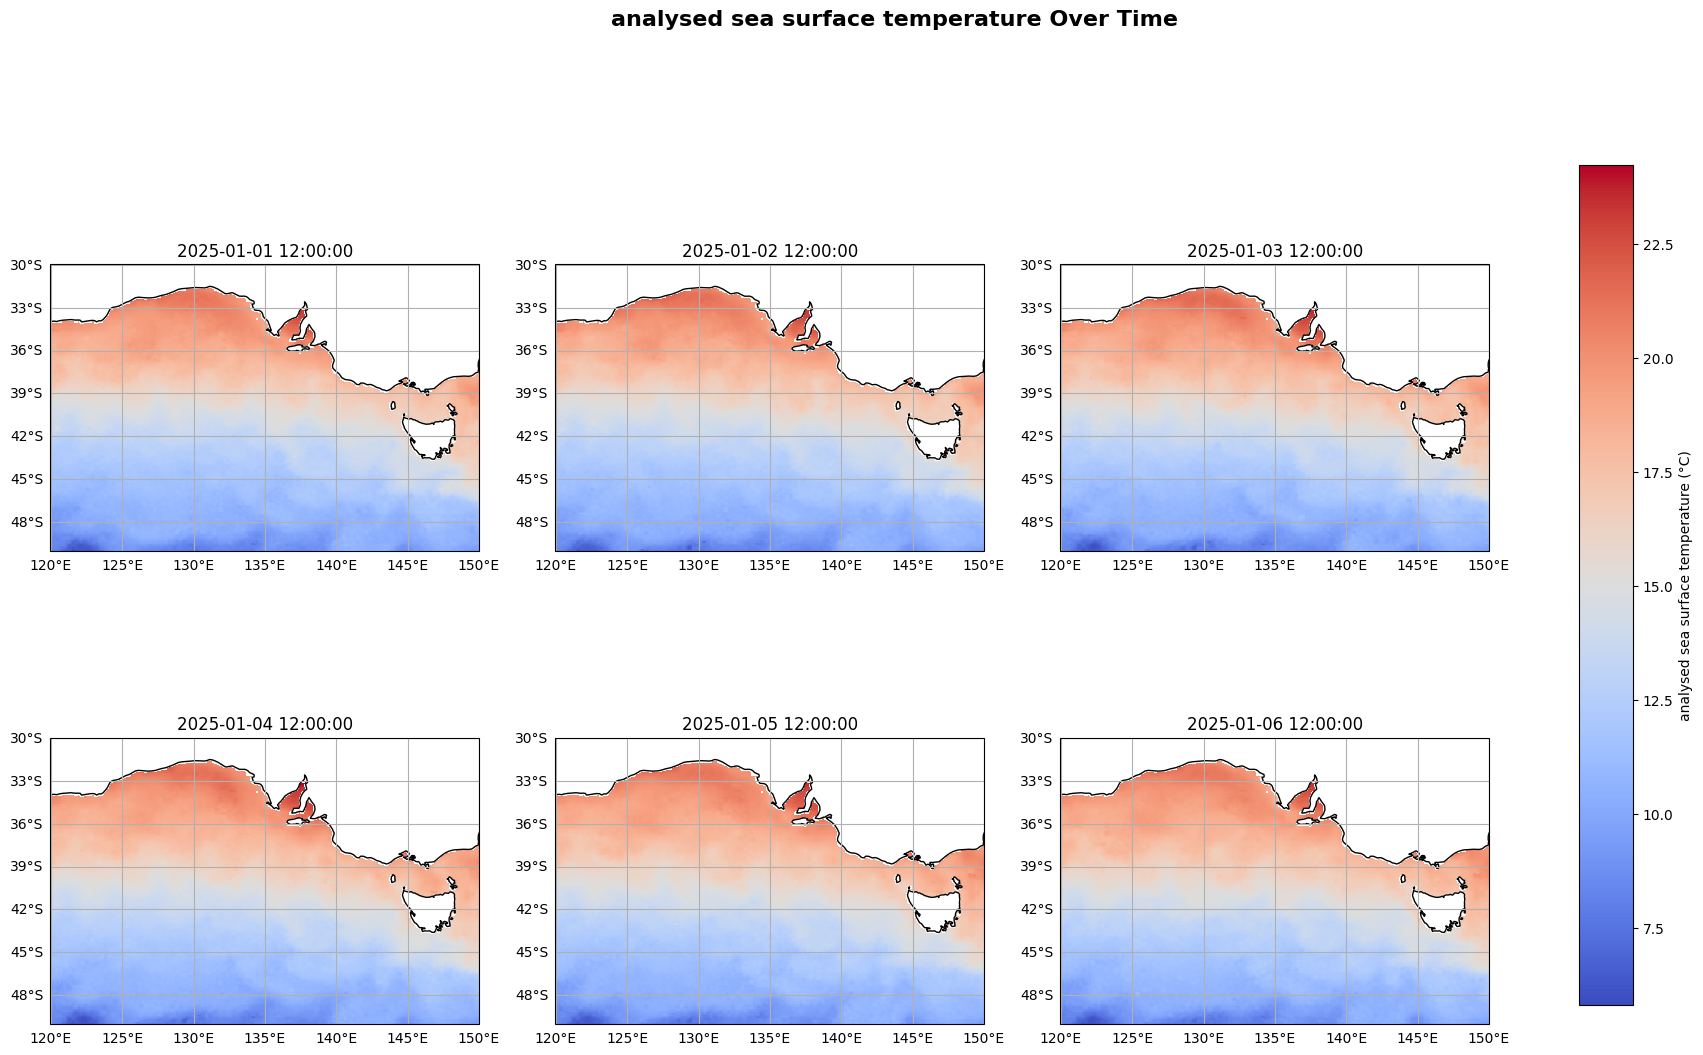

CPU times: user 2.83 s, sys: 1.94 s, total: 4.76 s
Wall time: 7.42 s


In [9]:
%%time
time_series_df = aodn_dataset.plot_gridded_variable(var_name='analysed_sst', 
                                                    date_start='2025-01-01',                                                
                                                    lon_name_override="lon", 
                                                    lat_name_override="lat", 
                                                    lon_slice=(120, 150), 
                                                    lat_slice=(-50, -30), 
                                                    n_days=6, 
                                                    coastline_resolution="50m", 
                                                    log_scale=False)

2025-06-11 12:27:46,359 - aodn.GetAodn - INFO - Plotting 'analysed sea surface temperature' for 9 time steps.
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2510: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(


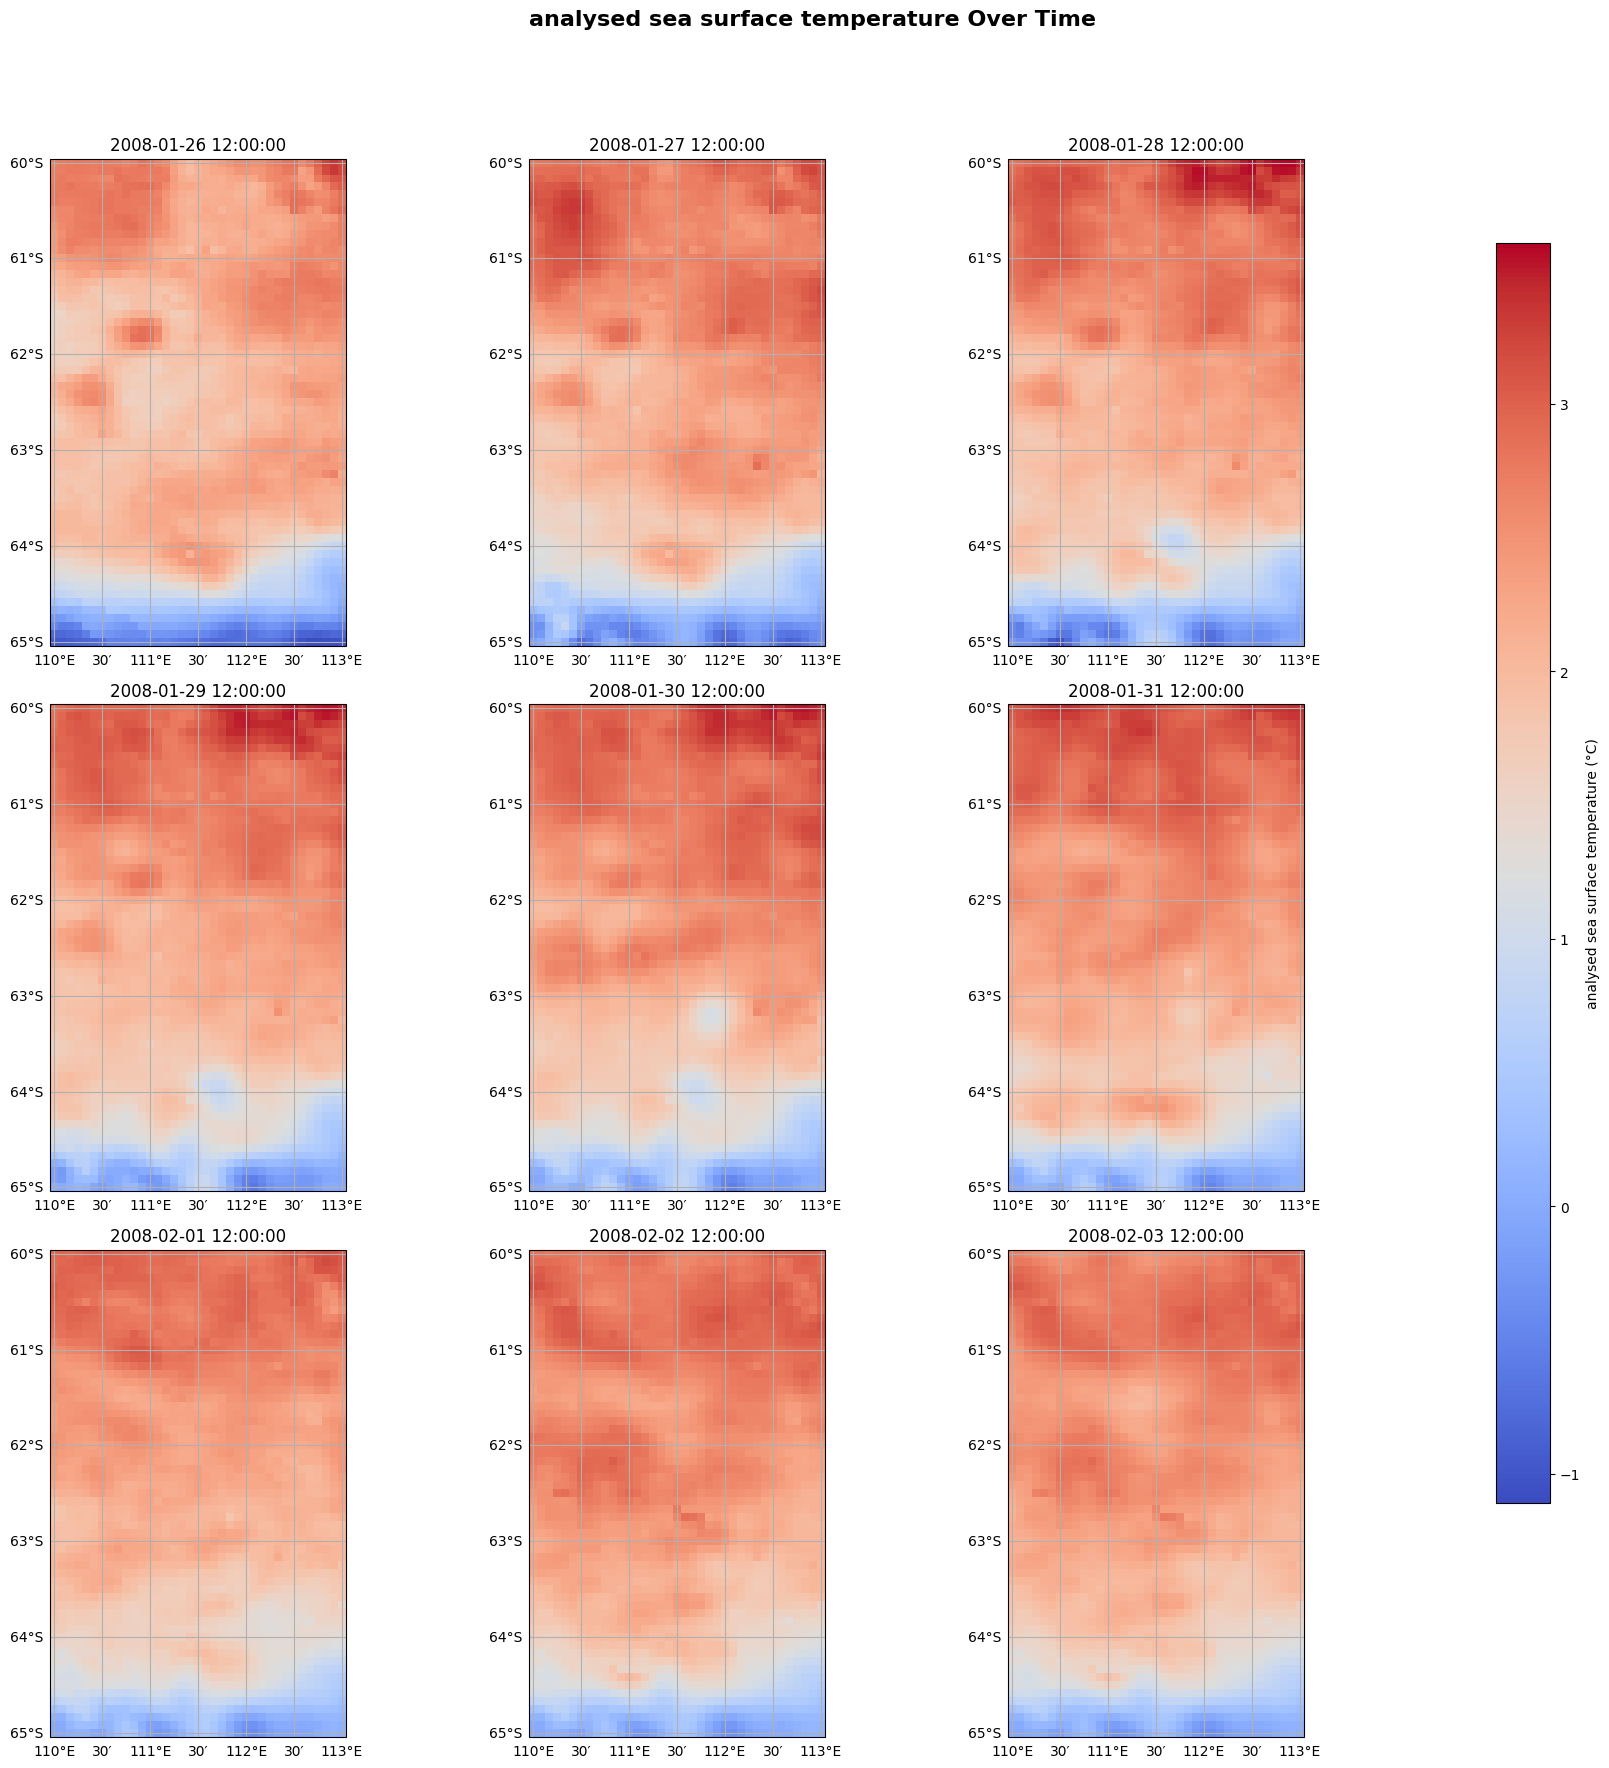

CPU times: user 2.79 s, sys: 2.14 s, total: 4.92 s
Wall time: 9.19 s


In [10]:
%%time
time_series_df = aodn_dataset.plot_gridded_variable(var_name='analysed_sst', 
                                                    date_start='2008-01-26',                                                
                                                    lon_name_override="lon", 
                                                    lat_name_override="lat", 
                                                    lon_slice=(110, 113), 
                                                    lat_slice=(-60, -65), 
                                                    n_days=9, 
                                                    coastline_resolution="50m", 
                                                    log_scale=False)

## Sea Ice Fraction

2025-06-11 12:27:55,558 - aodn.GetAodn - INFO - Plotting 'sea ice area fraction' for 9 time steps.
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2510: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(


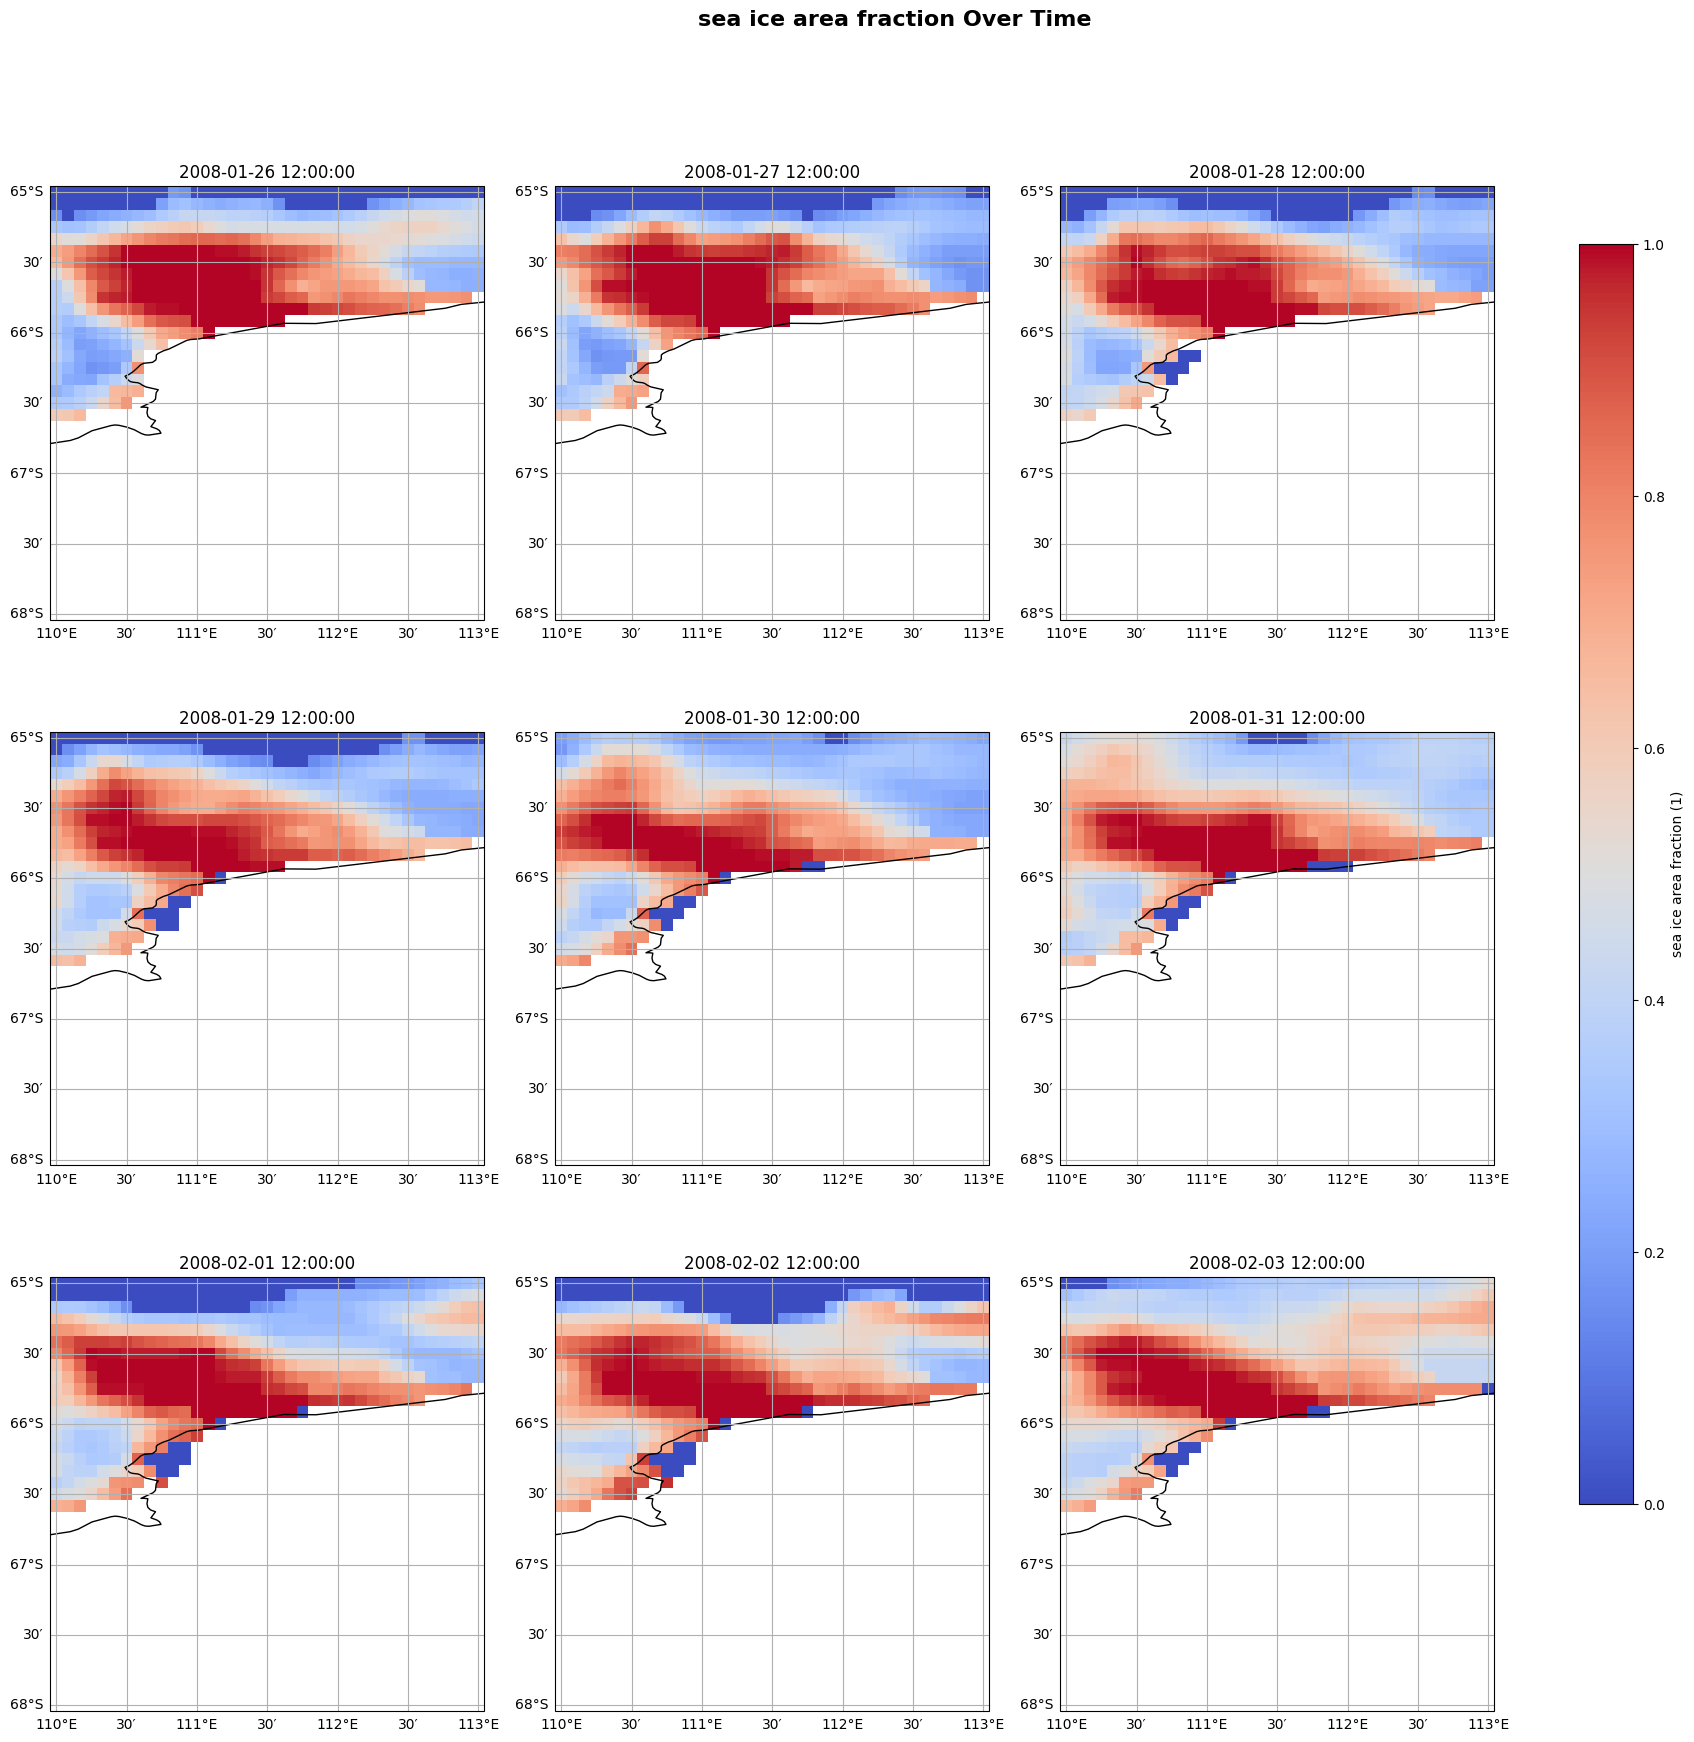

CPU times: user 3.33 s, sys: 2.68 s, total: 6.01 s
Wall time: 3.7 s


In [11]:
%%time
time_series_df = aodn_dataset.plot_gridded_variable(var_name='sea_ice_fraction', 
                                                    date_start='2008-01-26',                                                
                                                    lon_name_override="lon", 
                                                    lat_name_override="lat", 
                                                    lon_slice=(110, 113), 
                                                    lat_slice=(-68, -65), 
                                                    n_days=9, 
                                                    coastline_resolution="10m", 
                                                    log_scale=False)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def daily_avg_sea_ice_fraction(ds, lon_slice, lat_slice, start_date=None, end_date=None, var_name='sea_ice_fraction'):
    """
    Computes and plots the daily average of sea_ice_fraction over a given region (lon_slice, lat_slice)
    for a specified time range, bounded by dataset limits if necessary.

    Parameters:
    - ds: xarray.Dataset containing the sea ice data.
    - lon_slice: tuple, longitude slice (start_lon, end_lon). (min val, max val)
    - lat_slice: tuple, latitude slice (start_lat, end_lat). (min val, max val)
    - start_date: str, start date in 'YYYY-MM-DD' format (optional).
    - end_date: str, end date in 'YYYY-MM-DD' format (optional).
    - var_name: str, variable name to calculate the average for (default is 'sea_ice_fraction').

    Returns:
    - xarray.Dataset containing the daily average of sea_ice_fraction for the specified region and time period.
    """

    ds = ds.sortby('time')

    # Decide on the slice order
    if ds.lat[0] < ds.lat[-1]:
        lat_slice = lat_slice
    elif ds.lat[0] > ds.lat[-1]:  
        lat_slice = lat_slice[::-1]

    # Ensure the dataset has a time dimension
    assert 'time' in ds.dims, "Dataset does not have a 'time' dimension"

    # Determine the dataset's time range
    dataset_start = pd.to_datetime(ds.time.min().values)
    dataset_end = pd.to_datetime(ds.time.max().values)

    # Parse the start and end dates, default to dataset limits if necessary
    start_date = pd.to_datetime(start_date) if start_date else dataset_start
    end_date = pd.to_datetime(end_date) if end_date else dataset_end

    # Bound the start and end dates within the dataset's time range
    if start_date < dataset_start:
        start_date = dataset_start
    if end_date > dataset_end:
        end_date = dataset_end

    # Select the time range and area
    selected_data = ds.sel(
        lon=slice(lon_slice[0], lon_slice[1]),
        lat=slice(lat_slice[0], lat_slice[1]),
        time=slice(start_date, end_date)
    )

    # Create a mask for valid grid points (open sea or sea ice)
    valid_mask = (selected_data['mask'] == 1) | (selected_data['mask'] == 4)

    # Calculate the daily average over the filtered area using the valid mask
    daily_avg = selected_data[var_name].where(valid_mask).mean(dim=['lon', 'lat']).resample(time='1D').mean()


    # Calculate percentage of non-NaN values
    valid_data_count = valid_mask.count(dim=['lon', 'lat']).resample(time='1D').sum()
    total_data_count = selected_data['mask'].count(dim=['lon', 'lat']).resample(time='1D').sum()
    percentage_valid = (valid_data_count / total_data_count) * 100

    # Plot the time series of daily average sea_ice_fraction
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot daily average sea ice fraction
    daily_avg.plot(ax=ax1, color='blue', marker='o', linestyle='-', label='Daily Avg Sea Ice Fraction')
    ax1.set_ylabel(f"{ds[var_name].attrs.get('units', 'unitless')} (%)")
    ax1.set_title(f"Daily Average {ds[var_name].attrs.get('long_name', var_name)} ({start_date.date()} to {end_date.date()})")
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    ax1.grid(True)

    # Create a second y-axis to plot percentage of valid data
    ax2 = ax1.twinx()
    percentage_valid.plot(ax=ax2, color='orange', marker='x', linestyle='-', label='Percentage of Measured Data Points in Grid')
    ax2.set_ylabel("Percentage of Measured Data Points in Grid (%)")
    ax2.set_ylim(0, 100)  # Set limits for the percentage axis

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()

    # Return the daily average as an xarray.Dataset
    return daily_avg.to_dataset(name=f'daily_avg_{var_name}')

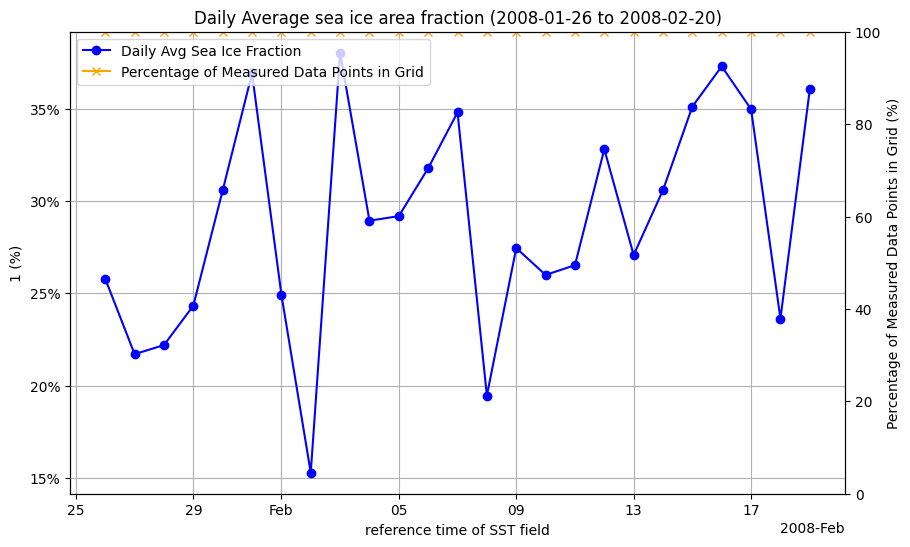

In [13]:
result_ds = daily_avg_sea_ice_fraction(ds, lon_slice=(110, 113), lat_slice=(-68, -65), start_date='2008-01-26',  end_date='2008-02-20', var_name='sea_ice_fraction')